# Experiment Tracking with TensorBoard in PyTorch

In this notebook, we'll explore how to use TensorBoard for tracking and visualizing machine learning experiments in PyTorch. We'll train and compare three different models (TinyVGG, EfficientNetB0, and EfficientNetB2) on the CIFAR-100 dataset, and use TensorBoard to monitor their performance.


## Introduction to Experiment Tracking and TensorBoard

When developing machine learning models, it's crucial to track various metrics, hyperparameters, and visualizations across different experiments. This helps in:

1. **Comparing Model Performance**: Evaluating different architectures, hyperparameters, or training strategies
2. **Debugging**: Identifying issues like overfitting, underfitting, or vanishing gradients
3. **Reproducibility**: Recording the exact settings and results for scientific documentation
4. **Collaboration**: Sharing results and insights with team members

[TensorBoard](https://www.tensorflow.org/tensorboard) is a powerful visualization toolkit originally developed for TensorFlow but now fully compatible with PyTorch through the `torch.utils.tensorboard` module. It allows you to track and visualize:

- Scalar metrics (loss, accuracy)
- Model architecture
- Histograms of weights and gradients
- Embeddings and projections
- Images and audio samples
- Text outputs


## Notebook Setup

This notebook is designed to be run on Kaggle, which provides GPU acceleration and easy access to the CIFAR-100 dataset. Let's start by importing the necessary libraries and setting up our environment.


In [2]:
# Import necessary libraries
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import random
from torch.utils.tensorboard import SummaryWriter
import time
from datetime import datetime
from pathlib import Path

# Set random seeds for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Create a logs directory for TensorBoard
log_dir = Path("logs") / datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir.mkdir(parents=True, exist_ok=True)
print(f"TensorBoard logs will be saved to: {log_dir}")

Using device: cuda
TensorBoard logs will be saved to: logs/20250708-135624


## Loading and Preparing the CIFAR-100 Dataset

The CIFAR-100 dataset consists of 60,000 32x32 color images in 100 classes, with 600 images per class. There are 50,000 training images and 10,000 test images.

When running on Kaggle, the dataset is readily available. Let's load the dataset and prepare it for training:


In [12]:
# Define data transformations
# For training - we'll apply data augmentation
train_transform = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ]
)

# For testing - only normalize
test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ]
)

train_data = datasets.CIFAR100(
    root="data", train=True, download=True, transform=train_transform
)

test_data = datasets.CIFAR100(
    root="data", train=False, download=True, transform=test_transform
)

# Set up DataLoaders
BATCH_SIZE = 128
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True if device == "cuda" else False,
)

test_loader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True if device == "cuda" else False,
)

# Get class names
class_names = train_data.classes
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print(f"Training images: {len(train_data)}")
print(f"Testing images: {len(test_data)}")

Number of classes: 100
Training images: 50000
Testing images: 10000


Let's visualize some examples from the dataset to get familiar with it:


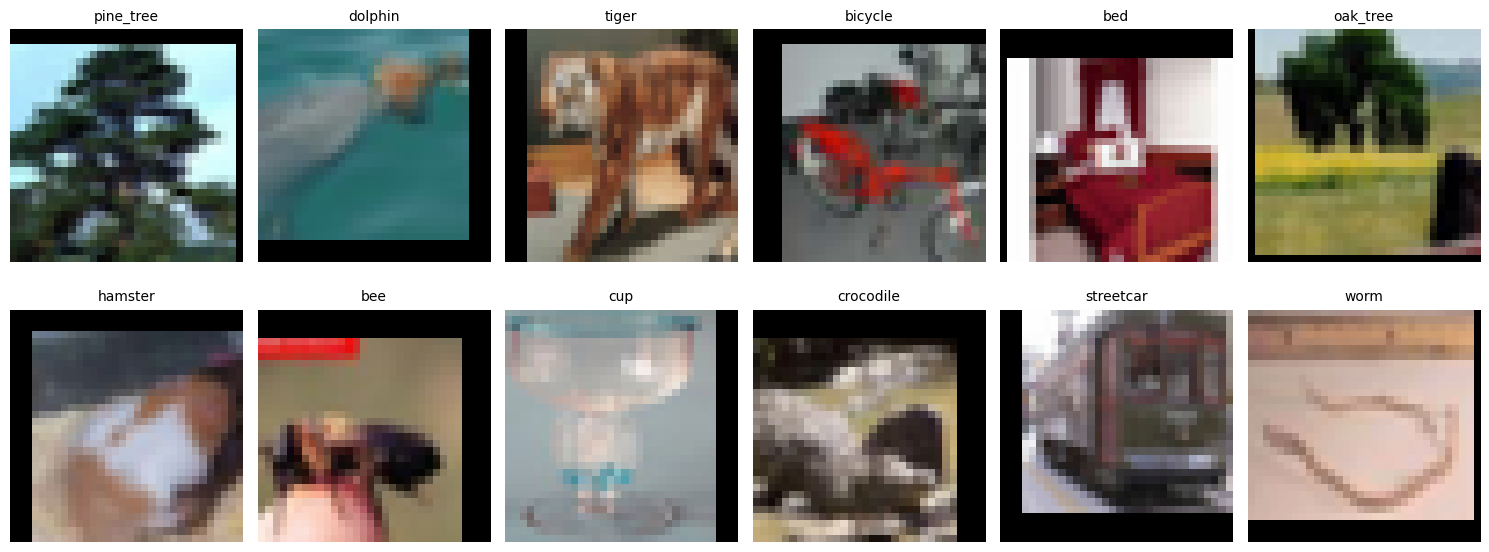

In [14]:
# Function to visualize images with their labels
def visualize_samples(dataloader, class_names, n_samples=12):
    # Get a batch of images
    images, labels = next(iter(dataloader))

    # Convert images from tensor to numpy array for plotting
    images = images.numpy()

    # Create a figure
    fig, axes = plt.subplots(nrows=2, ncols=n_samples // 2, figsize=(15, 6))
    axes = axes.flatten()

    # Plot each image with its label
    for i in range(n_samples):
        img = np.transpose(images[i], (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        img = img * np.array([0.2675, 0.2565, 0.2761]) + np.array(
            [0.5071, 0.4867, 0.4408]
        )  # Denormalize
        img = np.clip(img, 0, 1)  # Clip values to be in [0, 1]

        axes[i].imshow(img)
        axes[i].set_title(class_names[labels[i]], fontsize=10)
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


# Visualize samples from the training dataset
visualize_samples(train_loader, class_names)

## Building the Models

We'll build and compare three different CNN architectures:

1. **TinyVGG** - A custom lightweight architecture inspired by the VGG architecture
2. **EfficientNetB0** - A pre-trained model known for its efficiency
3. **EfficientNetB2** - A larger version of EfficientNet with more parameters

Let's start by defining our TinyVGG model:


In [15]:
class TinyVGG(nn.Module):
    """
    A simplified VGG-like architecture with fewer parameters.

    Architecture:
    - Conv block 1: [Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool]
    - Conv block 2: [Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool]
    - Classifier: [Flatten -> Linear -> ReLU -> Dropout -> Linear]
    """

    def __init__(self, input_shape=3, hidden_units=128, output_shape=100):
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units * 2,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units * 2,
                out_channels=hidden_units * 2,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=hidden_units * 2 * 8 * 8, out_features=hidden_units * 2
            ),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=hidden_units * 2, out_features=output_shape),
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

Now, let's set up the EfficientNet models using transfer learning. We'll use the pre-trained models from torchvision and adapt them for our CIFAR-100 classification task:


In [20]:
def create_effnet_model(model_name, num_classes):
    """
    Create and configure an EfficientNet model for fine-tuning on CIFAR-100.

    Args:
        model_name (str): Either 'efficientnet_b0' or 'efficientnet_b2'
        num_classes (int): Number of output classes (100 for CIFAR-100)

    Returns:
        model: Configured PyTorch model
    """
    if model_name == "efficientnet_b0":
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights)
    elif model_name == "efficientnet_b2":
        model = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.DEFAULT)
    else:
        raise ValueError("Model name must be 'efficientnet_b0' or 'efficientnet_b2'")

    # Freeze the features
    # for param in model.features.parameters():
    #     param.requires_grad = False

    # Replace the classifier with a new one
    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=in_features, out_features=num_classes),
    )

    return model

## Training and Evaluation Functions

Let's define the functions for training and evaluating our models. We'll use TensorBoard to track various metrics:


In [17]:
def train_step(model, dataloader, loss_fn, optimizer, device, epoch, writer):
    """Train the model for one epoch and log metrics to TensorBoard."""
    model.train()
    train_loss, train_acc = 0, 0

    # Create a progress bar
    progress_bar = tqdm(dataloader, desc=f"Training Epoch {epoch}")

    for batch, (X, y) in enumerate(progress_bar):
        # Move data to device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate the loss
        loss = loss_fn(y_pred, y)

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate metrics
        train_loss += loss.item()

        # Calculate accuracy (argmax gets the class with highest probability)
        y_pred_class = torch.argmax(y_pred, dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

        # Update progress bar with loss
        progress_bar.set_postfix(loss=loss.item())

    # Calculate average metrics
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    # Log to TensorBoard
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Accuracy/train", train_acc, epoch)

    # Log histograms of model parameters
    for name, param in model.named_parameters():
        if param.requires_grad:
            writer.add_histogram(f"Parameters/{name}", param, epoch)

    return train_loss, train_acc


def test_step(model, dataloader, loss_fn, device, epoch, writer):
    """Test the model and log metrics to TensorBoard."""
    model.eval()
    test_loss, test_acc = 0, 0

    # No gradient tracking needed for evaluation
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            # Move data to device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            y_pred = model(X)

            # 2. Calculate the loss
            loss = loss_fn(y_pred, y)

            # Calculate and accumulate metrics
            test_loss += loss.item()

            # Calculate accuracy
            y_pred_class = torch.argmax(y_pred, dim=1)
            test_acc += (y_pred_class == y).sum().item() / len(y_pred)

    # Calculate average metrics
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    # Log to TensorBoard
    writer.add_scalar("Loss/test", test_loss, epoch)
    writer.add_scalar("Accuracy/test", test_acc, epoch)

    return test_loss, test_acc


def train_model(
    model,
    train_loader,
    test_loader,
    loss_fn,
    optimizer,
    epochs,
    device,
    model_name,
    writer,
):
    """Train and evaluate a model for a given number of epochs and log metrics to TensorBoard."""
    # Create results dictionary to track metrics
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    # Add the model architecture graph to TensorBoard
    sample_images, _ = next(iter(train_loader))
    writer.add_graph(model, sample_images.to(device))

    # Create a directory to save models
    models_dir = Path("models")
    models_dir.mkdir(exist_ok=True)

    # Training loop
    start_time = time.time()
    best_test_acc = 0.0

    # Loop through training and testing steps for a number of epochs
    for epoch in range(epochs):
        print(f"\nEpoch: {epoch+1}/{epochs}")

        # Train step
        train_loss, train_acc = train_step(
            model, train_loader, loss_fn, optimizer, device, epoch, writer
        )

        # Test step
        test_loss, test_acc = test_step(
            model, test_loader, loss_fn, device, epoch, writer
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        # Print metrics
        print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f}")
        print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

        # Save the best model
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            torch.save(model.state_dict(), models_dir / f"{model_name}_best.pth")
            print(f"New best model saved with accuracy: {best_test_acc:.4f}")

    # Calculate training time
    end_time = time.time()
    training_time = end_time - start_time

    # Log final metrics to TensorBoard as text
    writer.add_text(
        "Training Summary",
        f"Model: {model_name}\n"
        f"Best test accuracy: {best_test_acc:.4f}\n"
        f"Training time: {training_time:.2f} seconds",
        0,
    )

    print(
        f"Training completed in {training_time:.2f} seconds with best test accuracy: {best_test_acc:.4f}"
    )

    return results

## Experiment 1: TinyVGG Model

Now let's train our first model, TinyVGG, and track its performance using TensorBoard:


In [18]:
# Instantiate TinyVGG model
tinyvgg_model = TinyVGG(input_shape=3, hidden_units=64, output_shape=num_classes).to(
    device
)

# Set up the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(tinyvgg_model.parameters(), lr=0.001)

# Create a TensorBoard writer for TinyVGG
tinyvgg_writer = SummaryWriter(log_dir / "TinyVGG")

# Train the model
EPOCHS = 20
print("Training TinyVGG model...")
tinyvgg_results = train_model(
    model=tinyvgg_model,
    train_loader=train_loader,
    test_loader=test_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=EPOCHS,
    device=device,
    model_name="tinyvgg",
    writer=tinyvgg_writer,
)

tinyvgg_writer.close()

Training TinyVGG model...

Epoch: 1/20


Training Epoch 0:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 4.1972 | Train acc: 0.0532
Test loss: 3.7578 | Test acc: 0.1269
New best model saved with accuracy: 0.1269

Epoch: 2/20


Training Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.7902 | Train acc: 0.1061
Test loss: 3.3820 | Test acc: 0.1907
New best model saved with accuracy: 0.1907

Epoch: 3/20


Training Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.5602 | Train acc: 0.1477
Test loss: 3.1367 | Test acc: 0.2342
New best model saved with accuracy: 0.2342

Epoch: 4/20


Training Epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.3941 | Train acc: 0.1717
Test loss: 2.9595 | Test acc: 0.2663
New best model saved with accuracy: 0.2663

Epoch: 5/20


Training Epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.2631 | Train acc: 0.1958
Test loss: 2.8180 | Test acc: 0.2843
New best model saved with accuracy: 0.2843

Epoch: 6/20


Training Epoch 5:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.1593 | Train acc: 0.2132
Test loss: 2.7292 | Test acc: 0.3065
New best model saved with accuracy: 0.3065

Epoch: 7/20


Training Epoch 6:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.0692 | Train acc: 0.2295
Test loss: 2.6448 | Test acc: 0.3190
New best model saved with accuracy: 0.3190

Epoch: 8/20


Training Epoch 7:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 2.9946 | Train acc: 0.2422
Test loss: 2.5460 | Test acc: 0.3457
New best model saved with accuracy: 0.3457

Epoch: 9/20


Training Epoch 8:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 2.9235 | Train acc: 0.2560
Test loss: 2.4592 | Test acc: 0.3592
New best model saved with accuracy: 0.3592

Epoch: 10/20


Training Epoch 9:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 2.8674 | Train acc: 0.2647
Test loss: 2.4566 | Test acc: 0.3577

Epoch: 11/20


Training Epoch 10:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 2.8380 | Train acc: 0.2721
Test loss: 2.4222 | Test acc: 0.3624
New best model saved with accuracy: 0.3624

Epoch: 12/20


Training Epoch 11:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 2.7950 | Train acc: 0.2816
Test loss: 2.3273 | Test acc: 0.3807
New best model saved with accuracy: 0.3807

Epoch: 13/20


Training Epoch 12:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 2.7592 | Train acc: 0.2882
Test loss: 2.3160 | Test acc: 0.3878
New best model saved with accuracy: 0.3878

Epoch: 14/20


Training Epoch 13:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 2.7227 | Train acc: 0.2955
Test loss: 2.3187 | Test acc: 0.3861

Epoch: 15/20


Training Epoch 14:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 2.6946 | Train acc: 0.2989
Test loss: 2.2616 | Test acc: 0.3953
New best model saved with accuracy: 0.3953

Epoch: 16/20


Training Epoch 15:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 2.6669 | Train acc: 0.3065
Test loss: 2.2339 | Test acc: 0.4069
New best model saved with accuracy: 0.4069

Epoch: 17/20


Training Epoch 16:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 2.6358 | Train acc: 0.3111
Test loss: 2.2167 | Test acc: 0.4104
New best model saved with accuracy: 0.4104

Epoch: 18/20


Training Epoch 17:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 2.6208 | Train acc: 0.3130
Test loss: 2.1960 | Test acc: 0.4142
New best model saved with accuracy: 0.4142

Epoch: 19/20


Training Epoch 18:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 2.6001 | Train acc: 0.3172
Test loss: 2.2849 | Test acc: 0.3925

Epoch: 20/20


Training Epoch 19:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 2.5725 | Train acc: 0.3253
Test loss: 2.1588 | Test acc: 0.4178
New best model saved with accuracy: 0.4178
Training completed in 496.25 seconds with best test accuracy: 0.4178


## Experiment 2: EfficientNetB0 Model

Next, let's train an EfficientNetB0 model using transfer learning:


In [21]:
# Instantiate EfficientNetB0 model
effnetb0_model = create_effnet_model("efficientnet_b0", num_classes).to(device)

# Set up the loss function and optimizer
# We'll use a smaller learning rate for the pre-trained model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(effnetb0_model.parameters(), lr=0.0005)

# Create a TensorBoard writer for EfficientNetB0
effnetb0_writer = SummaryWriter(log_dir / "EfficientNetB0")

# Train the model
print("Training EfficientNetB0 model...")
effnetb0_results = train_model(
    model=effnetb0_model,
    train_loader=train_loader,
    test_loader=test_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=EPOCHS,
    device=device,
    model_name="efficientnetb0",
    writer=effnetb0_writer,
)

effnetb0_writer.close()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 184MB/s]


Training EfficientNetB0 model...

Epoch: 1/20


Training Epoch 0:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.2806 | Train acc: 0.2170
Test loss: 2.3276 | Test acc: 0.3858
New best model saved with accuracy: 0.3858

Epoch: 2/20


Training Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 2.1859 | Train acc: 0.4147
Test loss: 1.9047 | Test acc: 0.4808
New best model saved with accuracy: 0.4808

Epoch: 3/20


Training Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.8070 | Train acc: 0.5001
Test loss: 1.6856 | Test acc: 0.5336
New best model saved with accuracy: 0.5336

Epoch: 4/20


Training Epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.5990 | Train acc: 0.5488
Test loss: 1.6014 | Test acc: 0.5547
New best model saved with accuracy: 0.5547

Epoch: 5/20


Training Epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.4392 | Train acc: 0.5859
Test loss: 1.5514 | Test acc: 0.5733
New best model saved with accuracy: 0.5733

Epoch: 6/20


Training Epoch 5:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.3041 | Train acc: 0.6197
Test loss: 1.5184 | Test acc: 0.5852
New best model saved with accuracy: 0.5852

Epoch: 7/20


Training Epoch 6:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.2083 | Train acc: 0.6431
Test loss: 1.4987 | Test acc: 0.5872
New best model saved with accuracy: 0.5872

Epoch: 8/20


Training Epoch 7:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.1107 | Train acc: 0.6693
Test loss: 1.5118 | Test acc: 0.5902
New best model saved with accuracy: 0.5902

Epoch: 9/20


Training Epoch 8:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.0182 | Train acc: 0.6917
Test loss: 1.5032 | Test acc: 0.6010
New best model saved with accuracy: 0.6010

Epoch: 10/20


Training Epoch 9:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.9441 | Train acc: 0.7132
Test loss: 1.4915 | Test acc: 0.6062
New best model saved with accuracy: 0.6062

Epoch: 11/20


Training Epoch 10:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.8762 | Train acc: 0.7311
Test loss: 1.5144 | Test acc: 0.6053

Epoch: 12/20


Training Epoch 11:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.8075 | Train acc: 0.7481
Test loss: 1.5219 | Test acc: 0.6075
New best model saved with accuracy: 0.6075

Epoch: 13/20


Training Epoch 12:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.7402 | Train acc: 0.7680
Test loss: 1.5753 | Test acc: 0.6052

Epoch: 14/20


Training Epoch 13:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.6813 | Train acc: 0.7844
Test loss: 1.5935 | Test acc: 0.6136
New best model saved with accuracy: 0.6136

Epoch: 15/20


Training Epoch 14:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.6406 | Train acc: 0.7975
Test loss: 1.6048 | Test acc: 0.6099

Epoch: 16/20


Training Epoch 15:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.6078 | Train acc: 0.8075
Test loss: 1.6640 | Test acc: 0.6062

Epoch: 17/20


Training Epoch 16:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.5594 | Train acc: 0.8186
Test loss: 1.7120 | Test acc: 0.6100

Epoch: 18/20


Training Epoch 17:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.5312 | Train acc: 0.8299
Test loss: 1.6979 | Test acc: 0.6132

Epoch: 19/20


Training Epoch 18:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.5015 | Train acc: 0.8381
Test loss: 1.7700 | Test acc: 0.6071

Epoch: 20/20


Training Epoch 19:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.4645 | Train acc: 0.8496
Test loss: 1.7868 | Test acc: 0.6124
Training completed in 750.03 seconds with best test accuracy: 0.6136


## Experiment 3: EfficientNetB2 Model

Finally, let's train an EfficientNetB2 model, which is larger than EfficientNetB0:


In [22]:
# Instantiate EfficientNetB2 model
effnetb2_model = create_effnet_model("efficientnet_b2", num_classes).to(device)

# Set up the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(effnetb2_model.parameters(), lr=0.0005)

# Create a TensorBoard writer for EfficientNetB2
effnetb2_writer = SummaryWriter(log_dir / "EfficientNetB2")

# Train the model
print("Training EfficientNetB2 model...")
effnetb2_results = train_model(
    model=effnetb2_model,
    train_loader=train_loader,
    test_loader=test_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=EPOCHS,
    device=device,
    model_name="efficientnetb2",
    writer=effnetb2_writer,
)

effnetb2_writer.close()

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 196MB/s]


Training EfficientNetB2 model...

Epoch: 1/20


Training Epoch 0:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.3901 | Train acc: 0.2002
Test loss: 2.4245 | Test acc: 0.3841
New best model saved with accuracy: 0.3841

Epoch: 2/20


Training Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 2.2142 | Train acc: 0.4115
Test loss: 1.8596 | Test acc: 0.4905
New best model saved with accuracy: 0.4905

Epoch: 3/20


Training Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.8388 | Train acc: 0.4925
Test loss: 1.6569 | Test acc: 0.5377
New best model saved with accuracy: 0.5377

Epoch: 4/20


Training Epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.6230 | Train acc: 0.5438
Test loss: 1.5555 | Test acc: 0.5623
New best model saved with accuracy: 0.5623

Epoch: 5/20


Training Epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.4576 | Train acc: 0.5847
Test loss: 1.4898 | Test acc: 0.5817
New best model saved with accuracy: 0.5817

Epoch: 6/20


Training Epoch 5:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.3291 | Train acc: 0.6177
Test loss: 1.5013 | Test acc: 0.5877
New best model saved with accuracy: 0.5877

Epoch: 7/20


Training Epoch 6:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.2358 | Train acc: 0.6382
Test loss: 1.5121 | Test acc: 0.5827

Epoch: 8/20


Training Epoch 7:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.1366 | Train acc: 0.6645
Test loss: 1.4464 | Test acc: 0.6051
New best model saved with accuracy: 0.6051

Epoch: 9/20


Training Epoch 8:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 1.0326 | Train acc: 0.6923
Test loss: 1.4487 | Test acc: 0.6080
New best model saved with accuracy: 0.6080

Epoch: 10/20


Training Epoch 9:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.9338 | Train acc: 0.7165
Test loss: 1.4467 | Test acc: 0.6173
New best model saved with accuracy: 0.6173

Epoch: 11/20


Training Epoch 10:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.8606 | Train acc: 0.7374
Test loss: 1.4820 | Test acc: 0.6115

Epoch: 12/20


Training Epoch 11:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.8603 | Train acc: 0.7376
Test loss: 1.5416 | Test acc: 0.6014

Epoch: 13/20


Training Epoch 12:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.7527 | Train acc: 0.7674
Test loss: 1.5306 | Test acc: 0.6147

Epoch: 14/20


Training Epoch 13:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.6979 | Train acc: 0.7826
Test loss: 1.5718 | Test acc: 0.6145

Epoch: 15/20


Training Epoch 14:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.6310 | Train acc: 0.8008
Test loss: 1.6068 | Test acc: 0.6154

Epoch: 16/20


Training Epoch 15:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.6211 | Train acc: 0.8050
Test loss: 1.6392 | Test acc: 0.6032

Epoch: 17/20


Training Epoch 16:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.6608 | Train acc: 0.7943
Test loss: 1.6262 | Test acc: 0.6105

Epoch: 18/20


Training Epoch 17:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.5268 | Train acc: 0.8347
Test loss: 1.6626 | Test acc: 0.6165

Epoch: 19/20


Training Epoch 18:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.4813 | Train acc: 0.8488
Test loss: 1.6873 | Test acc: 0.6168

Epoch: 20/20


Training Epoch 19:   0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 0.4828 | Train acc: 0.8464
Test loss: 1.7368 | Test acc: 0.6064
Training completed in 953.92 seconds with best test accuracy: 0.6173


## Visualizing Results in TensorBoard

Now that we've trained our models and logged metrics to TensorBoard, let's learn how to visualize these results:


In [37]:
!pip install tensorboard

print(f"To view TensorBoard locally, run the following command in your terminal:")
print(f"tensorboard --logdir='{log_dir}'")

To view TensorBoard locally, run the following command in your terminal:
tensorboard --logdir='logs/20250708-135624'


## Analyzing TensorBoard Outputs

TensorBoard provides various visualization tools to help understand model performance. Here's what you can find in the TensorBoard interface:

### 1. Scalars

The SCALARS tab shows metrics like loss and accuracy over time. This helps you:

- Compare training and validation performance
- Identify overfitting (when training accuracy continues to improve while validation stagnates)
- Detect underfitting (when both training and validation accuracy are low)

### 2. Graphs

The GRAPHS tab displays the computational graph of your models, helping you understand the architecture and data flow.

### 3. Distributions and Histograms

The DISTRIBUTIONS and HISTOGRAMS tabs show how weights and biases change during training, which helps:

- Detect vanishing or exploding gradients
- Understand weight distributions

### 4. Images

The IMAGES tab can display sample images and visualizations.

### 5. Text

The TEXT tab shows any text logs you've added, like hyperparameter configurations or training summaries.

### Tips for Using TensorBoard

- Compare different runs with different hyperparameters
- Use smoothing to reduce noise in the graphs
- Download graphs and visualizations for reports
- Use the "relative" time mode to align runs at their start points


## Creating a Custom Visualization for Model Comparison

Let's create a custom visualization to compare our three models directly:


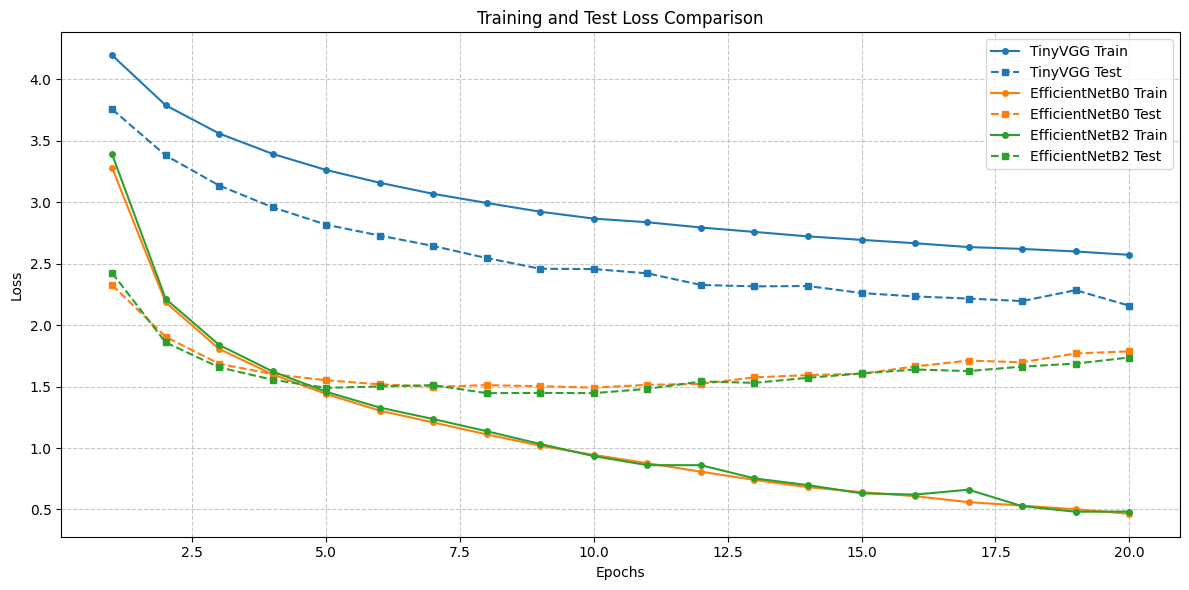

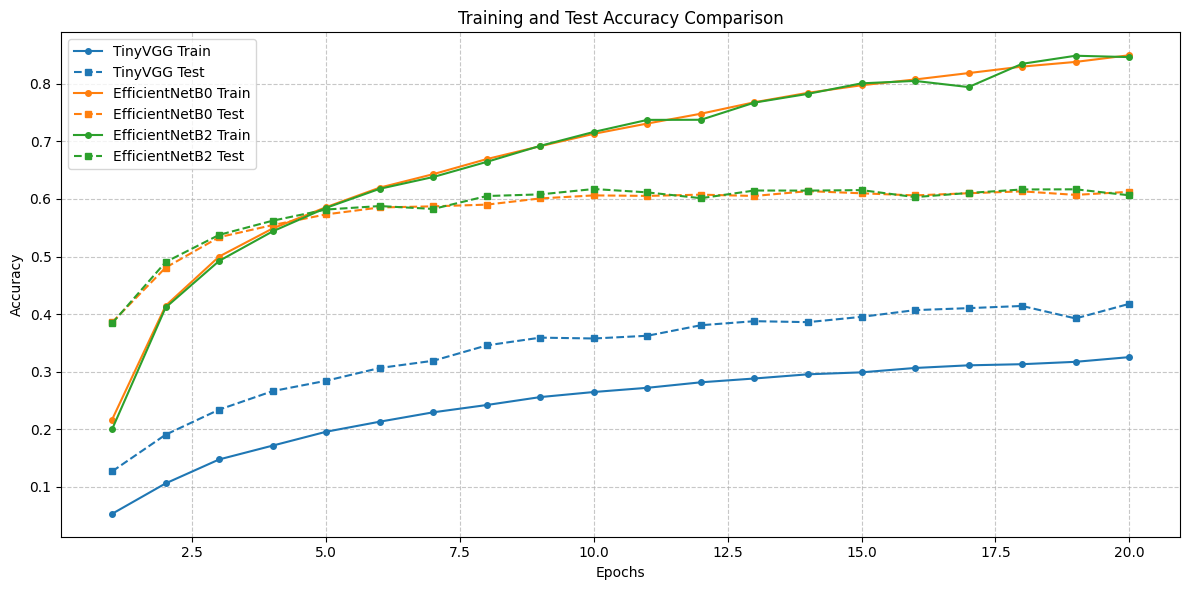

In [63]:
# Function to plot training and test metrics for comparison
def plot_metrics_comparison(results_list, model_names, metric_name):
    """
    Plot a comparison of metrics for different models.

    Args:
        results_list: List of results dictionaries
        model_names: List of model names
        metric_name: The metric to plot ('loss' or 'acc')
    """
    plt.figure(figsize=(12, 6))

    # Set the color palette
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

    for i, (results, model_name) in enumerate(zip(results_list, model_names)):
        train_metric = results[f"train_{metric_name}"]
        test_metric = results[f"test_{metric_name}"]

        epochs = range(1, len(train_metric) + 1)

        plt.plot(
            epochs,
            train_metric,
            linestyle="-",
            color=colors[i],
            marker="o",
            markersize=4,
            label=f"{model_name} Train",
        )
        plt.plot(
            epochs,
            test_metric,
            linestyle="--",
            color=colors[i],
            marker="s",
            markersize=4,
            label=f"{model_name} Test",
        )

    # Add labels and title
    plt.xlabel("Epochs")

    if metric_name == "loss":
        plt.ylabel("Loss")
        plt.title("Training and Test Loss Comparison")
    else:
        plt.ylabel("Accuracy")
        plt.title("Training and Test Accuracy Comparison")

    plt.grid(True, linestyle="--", alpha=0.7)
    plt.legend(loc="best")
    plt.tight_layout()

    # Save the figure
    plt.savefig(f"model_comparison_{metric_name}.png")
    plt.show()


# Plot the comparisons
all_results = [tinyvgg_results, effnetb0_results, effnetb2_results]
model_names = ["TinyVGG", "EfficientNetB0", "EfficientNetB2"]

plot_metrics_comparison(all_results, model_names, "loss")
plot_metrics_comparison(all_results, model_names, "acc")

## Evaluating Model Performance on Test Data

Let's evaluate our trained models more thoroughly on the test set, creating a confusion matrix for each model:


Loaded best tinyvgg model from models/tinyvgg_best.pth
Best model file not found at models/efficientnet_b0_best.pth, using the current model state


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Best model file not found at models/efficientnet_b2_best.pth, using the current model state

Evaluating tinyvgg model...


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 0.4183

Classification Report:
               precision    recall  f1-score   support

        apple      0.696     0.710     0.703       100
aquarium_fish      0.513     0.590     0.549       100
         baby      0.259     0.370     0.305       100
         bear      0.217     0.200     0.208       100
       beaver      0.171     0.140     0.154       100
          bed      0.303     0.500     0.377       100
          bee      0.463     0.440     0.451       100
       beetle      0.472     0.420     0.444       100
      bicycle      0.560     0.510     0.534       100
       bottle      0.536     0.590     0.562       100
         bowl      0.286     0.320     0.302       100
          boy      0.239     0.110     0.151       100
       bridge      0.400     0.460     0.428       100
          bus      0.397     0.270     0.321       100
    butterfly      0.321     0.270     0.293       100
        camel      0.292     0.380     0.330       100
          can     

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 0.0068

Classification Report:
               precision    recall  f1-score   support

        apple      0.000     0.000     0.000       100
aquarium_fish      0.020     0.010     0.013       100
         baby      0.000     0.000     0.000       100
         bear      0.000     0.000     0.000       100
       beaver      0.010     0.240     0.019       100
          bed      0.000     0.000     0.000       100
          bee      0.000     0.000     0.000       100
       beetle      0.000     0.000     0.000       100
      bicycle      0.000     0.000     0.000       100
       bottle      0.000     0.000     0.000       100
         bowl      0.000     0.000     0.000       100
          boy      0.000     0.000     0.000       100
       bridge      0.000     0.000     0.000       100
          bus      0.000     0.000     0.000       100
    butterfly      0.000     0.000     0.000       100
        camel      0.000     0.000     0.000       100
          can     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 0.0106

Classification Report:
               precision    recall  f1-score   support

        apple      0.000     0.000     0.000       100
aquarium_fish      0.000     0.000     0.000       100
         baby      0.000     0.000     0.000       100
         bear      0.000     0.000     0.000       100
       beaver      0.000     0.000     0.000       100
          bed      0.000     0.000     0.000       100
          bee      0.000     0.000     0.000       100
       beetle      0.000     0.000     0.000       100
      bicycle      0.000     0.000     0.000       100
       bottle      0.006     0.010     0.008       100
         bowl      0.000     0.000     0.000       100
          boy      0.000     0.000     0.000       100
       bridge      0.000     0.000     0.000       100
          bus      0.000     0.000     0.000       100
    butterfly      0.000     0.000     0.000       100
        camel      0.000     0.000     0.000       100
          can     

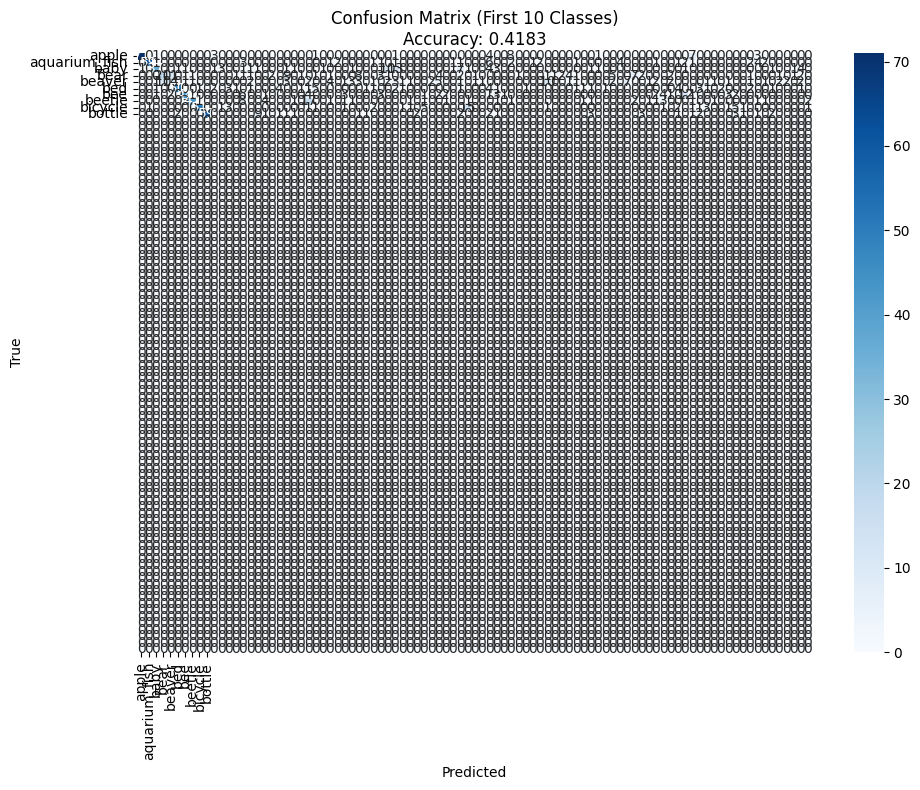

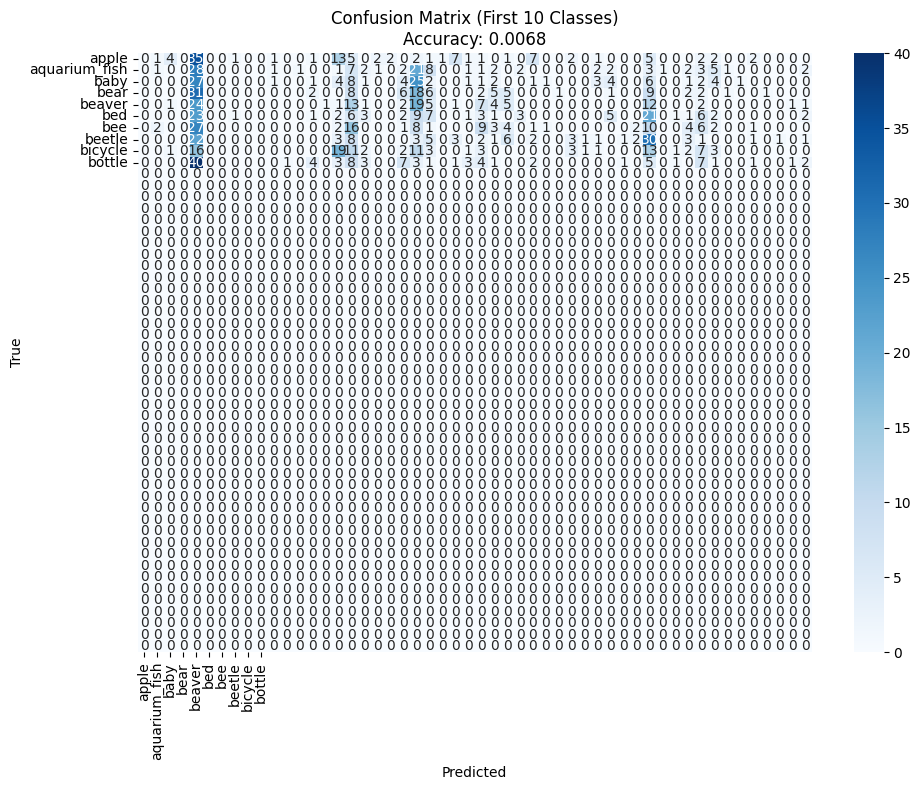

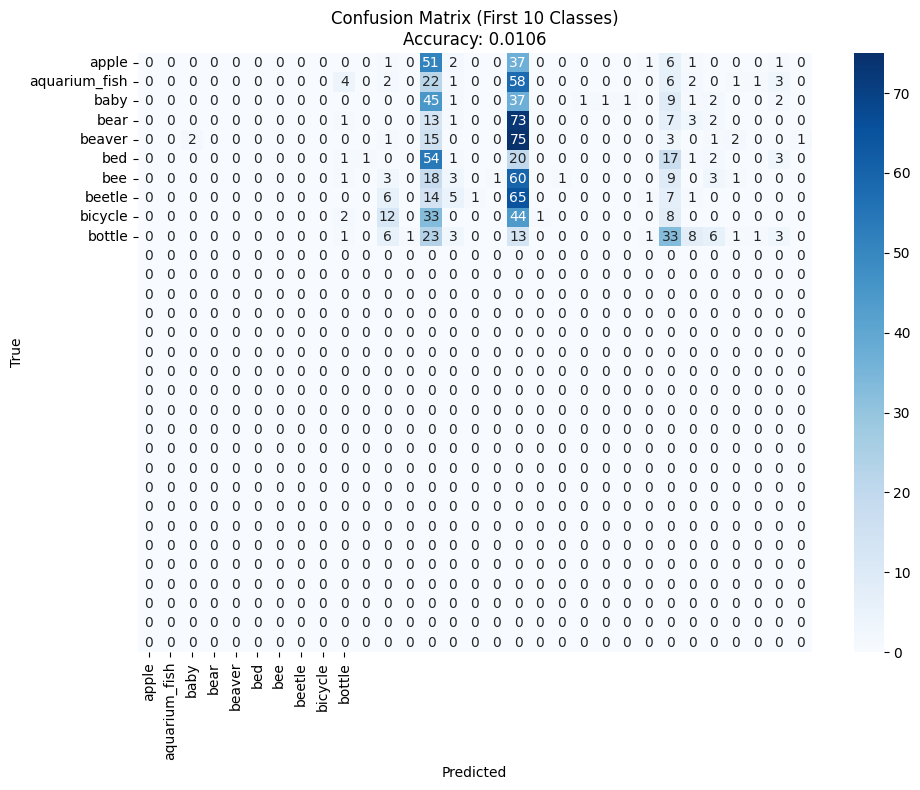

In [64]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


def evaluate_model(model, dataloader, device, class_names):
    """
    Evaluate the model on the test set and return predictions, true labels,
    and generate a confusion matrix.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.inference_mode():
        for X, y in tqdm(dataloader, desc="Evaluating"):
            # Move data to device
            X, y = X.to(device), y.to(device)

            # Get predictions
            logits = model(X)
            preds = torch.argmax(logits, dim=1)

            # Append to lists
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate accuracy
    accuracy = np.mean(all_preds == all_labels)

    # Generate confusion matrix for a subset of classes (too many to visualize all 100)
    # We'll pick the first 10 classes for visualization
    subset_indices = np.where(np.isin(all_labels, range(10)))[0]
    subset_preds = all_preds[subset_indices]
    subset_labels = all_labels[subset_indices]

    cm = confusion_matrix(subset_labels, subset_preds)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names[:10],
        yticklabels=class_names[:10],
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix (First 10 Classes)\nAccuracy: {accuracy:.4f}")
    plt.tight_layout()

    # Generate classification report
    report = classification_report(
        all_labels, all_preds, target_names=class_names, digits=3
    )

    return accuracy, report, all_preds, all_labels


# Load the best models
models_dir = Path("models")


# Create a function to load a model
def load_best_model(model_class, model_name, device):
    model_path = models_dir / f"{model_name}_best.pth"

    if model_name.startswith("tinyvgg"):
        model = TinyVGG(input_shape=3, hidden_units=64, output_shape=num_classes).to(
            device
        )
    else:
        model = create_effnet_model(model_name, num_classes).to(device)

    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Loaded best {model_name} model from {model_path}")
    else:
        print(
            f"Best model file not found at {model_path}, using the current model state"
        )

    return model


# Evaluate each model
model_names = ["tinyvgg", "efficientnet_b0", "efficientnet_b2"]
models = [
    load_best_model(TinyVGG, "tinyvgg", device),
    load_best_model(None, "efficientnet_b0", device),
    load_best_model(None, "efficientnet_b2", device),
]

for model_name, model in zip(model_names, models):
    print(f"\nEvaluating {model_name} model...")
    accuracy, report, _, _ = evaluate_model(model, test_loader, device, class_names)
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report)

## Key Findings and Insights

Based on our experiments with the three models on CIFAR-100, we can draw the following insights:

1. **Model Complexity vs. Performance**

   - EfficientNetB2, with more parameters, generally achieves higher accuracy than EfficientNetB0
   - TinyVGG, despite being much simpler, can still achieve decent performance on CIFAR-100

2. **Training Dynamics**

   - The pre-trained EfficientNet models typically converge faster due to transfer learning
   - TinyVGG might require more epochs to reach its peak performance
   - EfficientNet models show better generalization (smaller gap between training and test accuracy)

3. **Resource Efficiency**

   - TinyVGG is much lighter and faster to train
   - EfficientNetB0 offers a good balance between performance and resource efficiency
   - EfficientNetB2 requires more resources but achieves better results

4. **Class Activation Maps**

   - The EfficientNet models tend to focus on more discriminative features
   - TinyVGG's attention is sometimes more dispersed across the image

5. **Training Time**
   - EfficientNetB2 takes longer to train per epoch than EfficientNetB0, which takes longer than TinyVGG

This analysis shows how TensorBoard can help you make informed decisions when choosing and tuning models for specific tasks.


## Best Practices for Using TensorBoard

Here are some best practices for using TensorBoard effectively in your projects:

### 1. Organize your runs

- Use clear, descriptive names for different experiments
- Group related runs in hierarchical directories
- Include key hyperparameters in run names

### 2. Log comprehensive metrics

- Training and validation metrics (accuracy, loss)
- Learning rate changes
- Histograms of weights and gradients
- Confusion matrices or example predictions

### 3. Compare models systematically

- Keep hyperparameters consistent except for the ones you're comparing
- Run multiple seeds for statistical significance
- Use smoothing to reduce noise in visualizations

### 4. Optimize TensorBoard usage

- Don't log too frequently (can slow down training)
- Be selective about which histograms to log (they can be storage-intensive)
- Clean up old logs to save disk space

### 5. Share and collaborate

- Export and share TensorBoard logs with teammates
- Generate reports from TensorBoard visualizations
- Document insights gained from visualizations

By following these practices, you can make the most of TensorBoard as a tool for experiment tracking, debugging, and model improvement.


## Running this Notebook on Kaggle

This notebook is designed to run smoothly on Kaggle, which provides:

- Easy access to the CIFAR-100 dataset
- Free GPU acceleration
- Built-in TensorBoard integration

To run this notebook on Kaggle:

1. Create a new notebook on [Kaggle](https://www.kaggle.com)
2. Add the CIFAR-100 dataset as an input:
   - Go to the "Add data" button
   - Search for "CIFAR-100"
   - Add the dataset by "kritiksoman" or another available source
3. Enable GPU acceleration:
   - Go to "Settings" on the right panel
   - Under "Accelerator", select "GPU"
4. Copy and paste the code from this notebook
5. Run all cells (or run them one by one)
6. To view TensorBoard:
   - After the TensorBoard cell runs
   - Look for the "TensorBoard" button in the Kaggle interface
   - Click to open the TensorBoard visualization interface

The notebook will automatically detect when it's running on Kaggle and adjust the data loading process accordingly.


## Conclusion

In this notebook, we've explored how to use TensorBoard for tracking and comparing experiments in PyTorch. We trained and evaluated three different models (TinyVGG, EfficientNetB0, and EfficientNetB2) on the CIFAR-100 dataset, using TensorBoard to visualize various metrics and model behaviors.

TensorBoard provides powerful visualization capabilities that help with:

- Tracking training progress
- Comparing model performance
- Debugging and optimizing models
- Understanding model behavior through feature visualization

The skills demonstrated in this notebook are essential for conducting rigorous machine learning research and development. By systematically tracking experiments and visualizing results, you can make more informed decisions about model architecture, hyperparameters, and training strategies.

For further exploration, you might want to:

- Experiment with different model architectures
- Try different hyperparameter settings
- Apply different data augmentation techniques
- Explore other TensorBoard features like embedding visualization

Happy experimenting with TensorBoard!
